In [1]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt

## Lorenz 96

In [2]:
def f(t, y, F):
    return (np.roll(y, -1) - np.roll(y, 2)) * np.roll(y, 1) - y + F

## Settings

In [3]:
# parameters
N = 40              # number of grid point
F = 8.0              # forcing term

Tmax = 10.          # time length of the experiment
dT = 0.05           # DA cycle length
nT = int(Tmax / dT) # number of cycles


## Nature run (no need to run again)

In [4]:
# settings of spin-up
sigma_x0 = 0.05  # size of initial perturpation
Tspinup = 100.  # initial spin-up time

# spin-up from a random initail value
x_t_0 = sigma_x0 * np.random.randn(N)

solver = ode(f).set_integrator('dopri5', nsteps=10000)
solver.set_initial_value(x_t_0, 0.).set_f_params(F)
solver.integrate(Tspinup)
x_t_save = np.array([solver.y], dtype='f8')

# create nature
solver = ode(f).set_integrator('dopri5')
solver.set_initial_value(x_t_save[0], 0.).set_f_params(F)

tt = 1
while solver.successful() and tt <= nT:
    solver.integrate(solver.t + dT)
    x_t_save = np.vstack([x_t_save, [solver.y]])
#    print('timestep =', tt, round(solver.t, 10))
    tt += 1

# save data
np.savetxt('x_t.txt', x_t_save)

## Initial condition

In [5]:
# settings of spin-up
sigma_x0 = 0.1  # size of initial perturpation
Tspinup = 100.  # initial spin-up time

# spin-up from a random initail value
x_a_0 = sigma_x0 * np.random.randn(N)

solver = ode(f).set_integrator('dopri5', nsteps=10000)
solver.set_initial_value(x_a_0, 0.).set_f_params(F)
solver.integrate(Tspinup)
x_a_init = np.array(solver.y, dtype='f8')

# save the initial condition for DA experiment
np.savetxt('x_a_init.txt', x_a_init)

# Data Assmilation
### settings

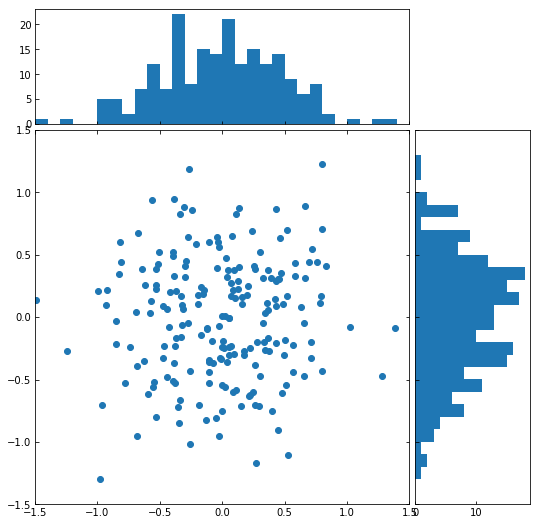

In [50]:
# load initial condition
x_a_init = np.genfromtxt('x_a_init.txt')
#x_a_init = np.genfromtxt('x_t.txt')[0] + 1.e-4  # using nature run value plus a small error (for test purpose)
# initial x_a: from x_a_init
x_a_save = np.array([x_a_init])

# load observations
x_t = np.genfromtxt('x_t.txt')
noise = np.random.normal(0, 0.5, x_t.shape)
y_o_save = x_t + noise  ###  Add random normal errors to the values in the nature run to create (a complete set of) simulated (synthetic) observations.


# initial x_b: no values at the initial time (assign NaN)
x_b_save = np.full((1,N), np.nan, dtype='f8')

## Check the observation error distribution and correlation
#plt.scatter(y_o_save[:,0],y_o_save[:,1])
e_1k = (y_o_save-x_t)[:,1]
e_2k = (y_o_save-x_t)[:,2]

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.01

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

# the scatter plot:
ax_scatter.scatter(e_1k, e_2k)

# now determine nice limits by hand:
binwidth = 0.1
lim = np.ceil(np.abs([e_1k, e_2k]).max() / binwidth) * binwidth
ax_scatter.set_xlim((-lim, lim))
ax_scatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(e_1k, bins=bins)
ax_histy.hist(e_2k, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

plt.show()


## DA methods: OI

In [57]:
tt = 1
while tt <= nT:
    tts = tt - 1
    Ts = tts * dT  # forecast start time
    Ta = tt  * dT  # forecast end time (DA analysis time)
    print('Cycle =', tt, ', Ts =', round(Ts, 10), ', Ta =', round(Ta, 10))

    #--------------
    # forecast step
    #--------------

    solver = ode(f).set_integrator('dopri5')
    solver.set_initial_value(x_a_save[tts], Ts).set_f_params(F)
    solver.integrate(Ta)
    x_b_save = np.vstack([x_b_save, [solver.y]])

    #--------------
    # analysis step
    #--------------

    # background
    x_b = x_b_save[tt].transpose()

    # observation
    y_o = y_o_save[tt].transpose()

    # innovation
    H = np.eye(N)
    y_b = np.dot(H, x_b) ## background on observation domain
    d = y_o - y_b
    
    # observation error
    e_o = np.var(noise, axis=0)
    R = np.diag(e_o)
    #print(R)
    # background error
    if tt == 1:
        P = R
        e_b = y_b - np.dot(H, x_t[tt].transpose())
    
    ### NMC method
    K = P.dot(H.T).dot(np.linalg.inv(H.dot(P).dot(H.T)+R))
    A = (np.eye(N)-K.dot(H)).dot(P)
    x_a = x_b + K.dot(y_o-H.dot(x_b))
    
    ## extend forecast
    P1 = A
    K1 = P1.dot(H.T).dot(np.linalg.inv(H.dot(P1).dot(H.T)+R))
    A1 = (np.eye(N)-K1.dot(H)).dot(P1)
    x_a1 = x_b + K1.dot(y_o-H.dot(x_b))
    
    if tt>1:
        alpha = 0.5
        x_p = x_a2-x_a1
        p_d = np.ones(20)
        for i in range(20):
            tmp = []
            for j in range(N):
                tmp.append(x_p[j-i]*x_p[j]) 
            p_d[i] =  np.mean(tmp) 
        for k in range(N):
            P[k-i,k] = alpha*p_d[i]
            P[k-39+i,k] = alpha*p_d[i]
    else:
        print(tt)
    P2 = A1
    K2 = P2.dot(H.T).dot(np.linalg.inv(H.dot(P2).dot(H.T)+R))
    A2 = (np.eye(N)-K2.dot(H)).dot(P2)
    x_a2 = x_b + K2.dot(y_o-H.dot(x_b))
    ### NMC end

    x_a_save = np.vstack([x_a_save, x_a.transpose()])
    tt += 1

# save background and analysis data
np.savetxt('x_b.txt', x_b_save)
np.savetxt('x_a.txt', x_a_save)


Cycle = 1 , Ts = 0.0 , Ta = 0.05
1
Cycle = 2 , Ts = 0.05 , Ta = 0.1
Cycle = 3 , Ts = 0.1 , Ta = 0.15
Cycle = 4 , Ts = 0.15 , Ta = 0.2
Cycle = 5 , Ts = 0.2 , Ta = 0.25
Cycle = 6 , Ts = 0.25 , Ta = 0.3
Cycle = 7 , Ts = 0.3 , Ta = 0.35
Cycle = 8 , Ts = 0.35 , Ta = 0.4
Cycle = 9 , Ts = 0.4 , Ta = 0.45
Cycle = 10 , Ts = 0.45 , Ta = 0.5
Cycle = 11 , Ts = 0.5 , Ta = 0.55
Cycle = 12 , Ts = 0.55 , Ta = 0.6
Cycle = 13 , Ts = 0.6 , Ta = 0.65
Cycle = 14 , Ts = 0.65 , Ta = 0.7
Cycle = 15 , Ts = 0.7 , Ta = 0.75
Cycle = 16 , Ts = 0.75 , Ta = 0.8
Cycle = 17 , Ts = 0.8 , Ta = 0.85
Cycle = 18 , Ts = 0.85 , Ta = 0.9
Cycle = 19 , Ts = 0.9 , Ta = 0.95
Cycle = 20 , Ts = 0.95 , Ta = 1.0
Cycle = 21 , Ts = 1.0 , Ta = 1.05
Cycle = 22 , Ts = 1.05 , Ta = 1.1
Cycle = 23 , Ts = 1.1 , Ta = 1.15
Cycle = 24 , Ts = 1.15 , Ta = 1.2
Cycle = 25 , Ts = 1.2 , Ta = 1.25
Cycle = 26 , Ts = 1.25 , Ta = 1.3
Cycle = 27 , Ts = 1.3 , Ta = 1.35
Cycle = 28 , Ts = 1.35 , Ta = 1.4
Cycle = 29 , Ts = 1.4 , Ta = 1.45
Cycle = 30 , Ts = 1.4

## Plot result

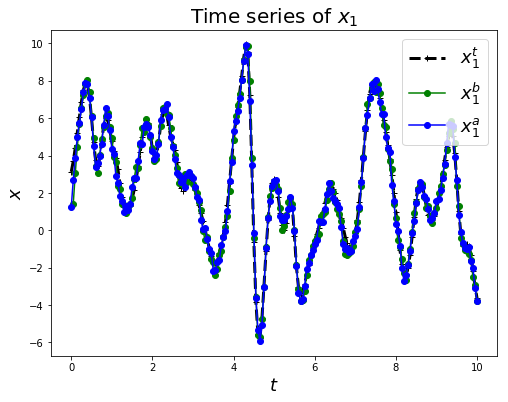

In [53]:
# load data
x_t_save = np.genfromtxt('x_t.txt')
x_b_save = np.genfromtxt('x_b.txt')
x_a_save = np.genfromtxt('x_a.txt')

# Plot time series of a single grid point
pt = 1
fig , ax = plt.subplots(figsize=(8,6))
plt.plot(np.arange(nT+1) * dT, x_t_save[:,pt-1], 'k+--', label=r'$x^t_{' + str(pt) + '}$',linewidth = 3)
plt.plot(np.arange(nT+1) * dT, x_b_save[:,pt-1], 'go-' , label=r'$x^b_{' + str(pt) + '}$')
plt.plot(np.arange(nT+1) * dT, x_a_save[:,pt-1], 'bo-' , label=r'$x^a_{' + str(pt) + '}$')
#print(x_a_save[:,pt-1])
plt.xlabel(r'$t$', size=18)
plt.ylabel(r'$x$', size=18)
plt.title(r'Time series of $x_{' + str(pt) + '}$', size=20)
plt.legend(loc='upper right', numpoints=1, prop={'size':18})
plt.savefig('timeseries.png', dpi=200)
plt.show()


In [45]:
from sklearn.metrics import mean_squared_error
pt = 1
RMSE_1 = mean_squared_error(x_a_save.T,x_t_save.T, multioutput='raw_values')
#RMSE_1 = mean_squared_error(x_a_save[1,:],x_t_save[1,:])
print(RMSE_1)

[24.217959    5.75316665  1.38145437  0.3609642   0.1675104   0.13749657
  0.11495224  0.14822197  0.08880308  0.0734319   0.12107502  0.1052692
  0.0849983   0.10694622  0.08310483  0.07379969  0.05794855  0.07761003
  0.06247325  0.06675437  0.06042284  0.07373541  0.09511094  0.07216771
  0.10655213  0.11459384  0.08172969  0.06329949  0.0664172   0.09383299
  0.07298714  0.10953661  0.10296988  0.10031968  0.11641319  0.10825969
  0.16664074  0.17069549  0.12420775  0.12172648  0.12620992  0.10583983
  0.07483349  0.07719882  0.08231333  0.06530658  0.07735564  0.08669194
  0.05964376  0.10537074  0.05312242  0.0844829   0.09672705  0.09608161
  0.07711198  0.10315795  0.07335938  0.09397826  0.08655426  0.07973139
  0.07365446  0.13580083  0.08900484  0.10651818  0.08906489  0.10081901
  0.08246018  0.0673454   0.098174    0.11501536  0.05830941  0.0829701
  0.07943829  0.07903655  0.0840104   0.16551951  0.15695607  0.17497435
  0.31533992  0.25893171  0.14805434  0.1170872   0.1

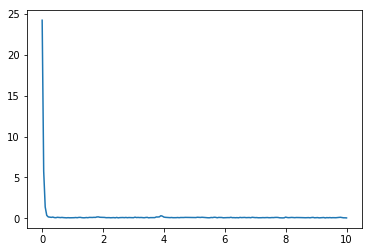

In [55]:
plt.plot(np.arange(nT+1) * dT,RMSE_1)